In [4]:
"""A tiny word2vec model for learning. This code is taken almost entirely from the d2l book, with modifications and further explanations for learning purposes."""

'A tiny word2vec model for learning.'

In [5]:
import collections 
import math 
import random 
import torch
from torch import nn
from vocab import Vocab
from d2l import torch as d2l

In [6]:
with open("../data/ptb/ptb.train.txt") as f:
    raw_text = f.read()
sentences = [line.split() for line in raw_text.split('\n')]

In [7]:
vocab = Vocab(sentences, min_freq=10)
len(vocab)

6719

## Subsampling

In [8]:
T = 1e-4

In [9]:
def discard_probability(t: float, freq: int, num_tokens: int) -> float:
    """
    Calculates the probability for this word to be discarded. 

    Parameters
    ----------
    t : float
        Hyperparameter to adjust for subsampling.
    freq : int
        Frequency of the word in the corpus.
    num_tokens : int
        Total number of tokens in the corpus.

    Returns
    -------
    float
        The probability for discarding this word.
    """
    return max(1 - math.sqrt(t / (freq / num_tokens)), 0)

def keep(prob: float) -> bool:
    """
    Returns True if this word is kept under the roll of a imaginary dice.

    Parameters
    ----------
    prob : float
        Probability for keeping

    Returns
    -------
    bool
        To keep or not to keep :)
    """
    rand = random.uniform(0, 1)
    return rand < prob

def subsample(sentences: list[list[str]], unk: str) -> tuple[list[list[str]], collections.Counter]:
    """
    Subsamples the words in the vocabulary according to their frequencies.

    Parameters
    ----------
    words : list[list[str]]
        All the words in the corpus
    unk : str
        The <unk> token in this case

    Returns
    -------
    tuple[list[list[str]], collections.Counter]
        The subsampled words and the counter
    """
    sentences = [[token for token in line if token != unk] for line in sentences]
    counter = collections.Counter([token for line in sentences for token in line])
    num_tokens = sum(counter.values())
    subsampled_sentences = [[token for token in line if keep(discard_probability(T, counter[token], num_tokens))] for line in sentences]
    return subsampled_sentences, counter

In [10]:
subsampled, counter = subsample(sentences, '<unk>')

## Extracting center words and context words 

In [11]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        if len(line) < 2:
            continue
        centers += line
        # adding the context for each word in that line
        # such that each element in center corresponds to a sublist of contexts
        for i in range(len(line)): 
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [12]:
# the total number of center context pairs would thus be the length of the flattened context list, each each word in that flattened list can be paired with a center word
all_centers, all_contexts = get_centers_and_contexts(subsampled, 5)

## Negative sampling

The softmax objective is too expensive to compute, negative sampling modifies the learning objective to make the learning problem much easier to approach. 

The problem is now, given two words, predict if they are context target pairs. We just extracted positive context target pair, and now we want negative examples - words that are not context target pairs. 

We define a logistic model, where c is the context word, t is the target word, and y is the label.

$ P(y = 1 | c, t) = \sigma (\theta_t^T e_c) $

In [13]:
K = 3 # number of negative examples per positive example

This is a much more simplified version of the algorithm that draws negative samples from the one described in the paper. Instead of drawing negative samples from a specific distribution, we are just going to randomly draw K of them from outside the context window. 

In [14]:
def random_draw(vocab):
    random_idx = random.randint(0, len(vocab) - 1)
    return vocab.to_tokens(random_idx)

In [15]:
def get_negative_samples(all_centers, all_contexts, vocab, K):
    all_negatives = []
    for center, context in zip(all_centers, all_contexts):
        negatives = []
        while len(negatives) <= len(context) * K:
            random_word = random_draw(vocab)
            if random_word not in context and random_word != center:
                negatives.append(random_word)
        all_negatives.append(negatives)
    return all_negatives

In [16]:
all_negatives = get_negative_samples(all_centers, all_contexts, vocab, K)

In [17]:
assert len(all_centers) == len(all_contexts) == len(all_negatives)

### Looking at some of the negatives and contexts just to make sure they look right

In [18]:
all_contexts[:2]

[['years', 'will'], ['N', 'will', 'the', 'board', 'a']]

In [19]:
all_negatives[:2]

[['millions', 'repeat', 'deadline', 'cathay', 'bar', 'per-share', 'option'],
 ['warner',
  'legislators',
  'exchequer',
  'neighborhood',
  'buyer',
  'furor',
  'and',
  'attract',
  'starting',
  'whether',
  'event',
  'largely',
  'platform',
  'reunification',
  'banco',
  'her']]

## Constructing the dataset with negatives and contexts

In [21]:
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [37]:
# had a rewritten version of this, but that was not working due to the # of workers, tried fixing it by pasting directly from the d2l cell but turns out my code wasn't the problem the # of workers was :/
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = 0
    sentences = [line.split() for line in raw_text.split('\n')]
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negative_samples(
        all_centers, all_contexts, vocab, num_noise_words)
    all_centers = vocab[all_centers]
    all_contexts = vocab[all_contexts]
    all_negatives = vocab[all_negatives]

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

## Pretraining

In [38]:
def skip_gram(center, contexts_negatives, embed_v, embed_u):
    """
    center is of shape (batch_size, 1)
    contexts_negatives is of shape (batch_size, max_len)
    embed_v is the embedding matrix used to translate from the index of the word in the vocabulary to the N dimensional tensor of the final word embedding
    embed_u is the same thing for the contexts_negatives.
    """
    v = embed_v(center) # this gets the embeddings for the center
    u = embed_u(contexts_negatives) # this gets the embeddings for the contexts and negatives
    # bmm is batch matrix multiplication. 
    # v is of the shape (batch_size, 1, embedding_dim)
    # u is of the shape (batch_size, max_len, embedding_dim), after permutation goes to (batch_size, embedding_dim, max_len)
    # and batch matrix multiplication takes each batch, and multiplies the two matrices in that batch together. 
    # so pred is of shape (batch_size, 1, max_len)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred 

In [39]:
# binary cross entropy loss, is a loss used for binary classification problems. 
class SigmoidBCELoss(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

In [40]:
embed_size = 50
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size), 
                    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

In [43]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.011, 95687.1 tokens/sec on cpu


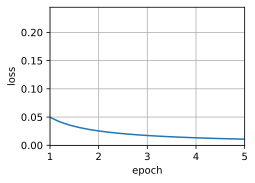

In [45]:
data_iter, vocab = load_data_ptb(512, 5, 5)
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)